In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

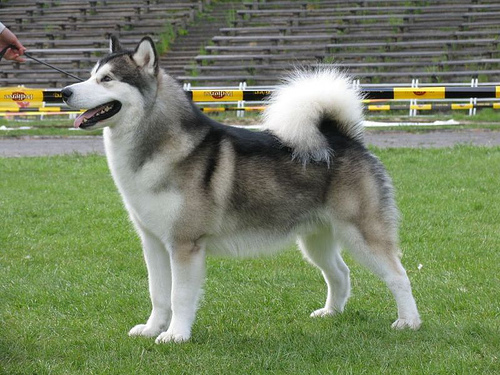

In [2]:
img_path = 'husky.jpg'
img = Image.open(img_path)
img

Shape of original color tensor: torch.Size([3, 375, 500])
Shape of grayscale tensor: torch.Size([1, 375, 500])


Shape of the final 2D matrix: torch.Size([375, 500])
Final 2D matrix: 
 tensor([[0.1601, 0.3219, 0.2871,  ..., 0.3680, 0.3523, 0.3405],
        [0.1610, 0.2733, 0.2573,  ..., 0.2944, 0.2827, 0.2787],
        [0.2105, 0.2585, 0.2629,  ..., 0.2190, 0.2112, 0.2151],
        ...,
        [0.2746, 0.3225, 0.3760,  ..., 0.4675, 0.4518, 0.3655],
        [0.4314, 0.3334, 0.2912,  ..., 0.5263, 0.4635, 0.3694],
        [0.2949, 0.2107, 0.2587,  ..., 0.4753, 0.5205, 0.4970]])


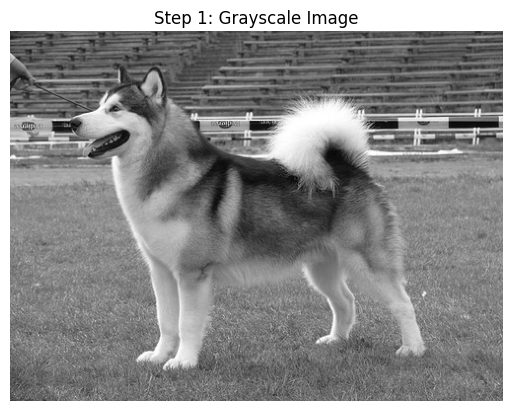

In [3]:
transform = transforms.ToTensor()
img_tensor = transform(img)
print("Shape of original color tensor:", img_tensor.shape)

grayscale_transform = transforms.Grayscale()

gray_tensor = grayscale_transform(img_tensor)
print("Shape of grayscale tensor:", gray_tensor.shape)
print('\n')
gray_img_tensor = gray_tensor.squeeze(0)
print("Shape of the final 2D matrix:", gray_img_tensor.shape)
print(f"Final 2D matrix: \n {gray_img_tensor}")

plt.imshow(gray_img_tensor, cmap='gray')
plt.title("Step 1: Grayscale Image")
plt.axis('off') # Hides the coordinate axes
plt.show()


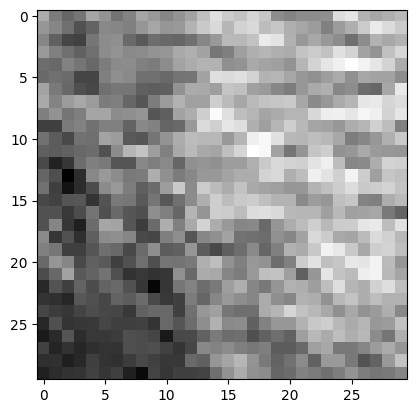

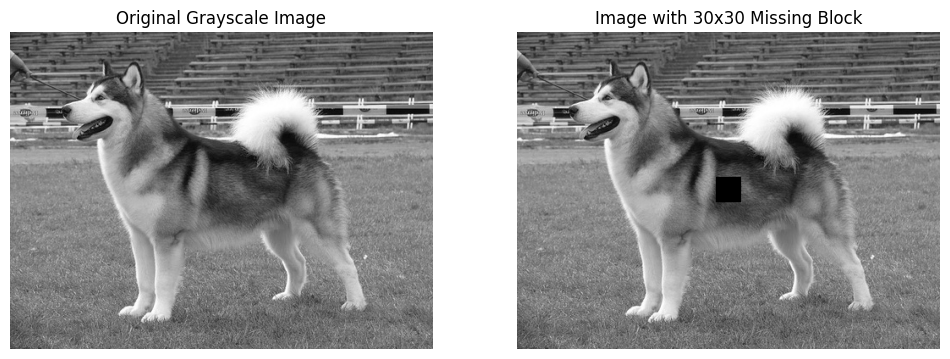

Mask and corrupted image have been created successfully!


In [4]:
H, W = gray_img_tensor.shape

patch_size = 30
start_h = H//2 - patch_size//2
end_h = H//2 + patch_size//2
start_w = W//2 - patch_size//2
end_w = W//2 + patch_size//2

# print(gray_img_tensor[start_h:end_h, start_w:end_w])
plt.imshow(gray_img_tensor[start_h:end_h, start_w:end_w], cmap='gray')


mask = torch.ones_like(gray_img_tensor)
mask[start_h:end_h, start_w:end_w] = 0

corrupted_img = gray_img_tensor * mask


# --- Display the results to verify ---
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(gray_img_tensor, cmap='gray')
ax[0].set_title("Original Grayscale Image")
ax[0].axis('off')

ax[1].imshow(corrupted_img, cmap='gray')
ax[1].set_title("Image with 30x30 Missing Block")
ax[1].axis('off')

plt.show()

print("Mask and corrupted image have been created successfully!")

In [ ]:
def full_batch_gd(gray_img_tensor, mask, r=150, lr=0.01, epochs=10000):
    H, W = gray_img_tensor.shape
    U = torch.randn(H, r, requires_grad=True)
    V = torch.randn(r, W, requires_grad=True)

    losses = []

    for epoch in range(epochs):
        reconst_img = U @ V
        loss = torch.mean(((gray_img_tensor - reconst_img)*mask) ** 2)
        losses.append(loss.item())
        loss.backward()

        # Update weights and that do not need to be in the computational graph
        with torch.no_grad():
            U -= lr * U.grad
            V -= lr * V.grad

        # gradients are set to 0 because when again loss.backward is calculated the gradient of w and b are added to w.grad and
        # b.grad repectively so to ensure the value of w.grad and b.grad is correct as soon as w.grad is used it is set to 0
        U.grad.zero_()
        V.grad.zero_()

        if (epoch + 1) % 2000 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.2f}")

    print("Gradient Descent finished!")

    return U, V, losses


U, V, losses = full_batch_gd(gray_img_tensor, mask)


Epoch 2000/10000, Loss: 96.46
Epoch 4000/10000, Loss: 67.19
Epoch 6000/10000, Loss: 49.33
Epoch 8000/10000, Loss: 37.57
Epoch 10000/10000, Loss: 29.41
Gradient Descent finished!


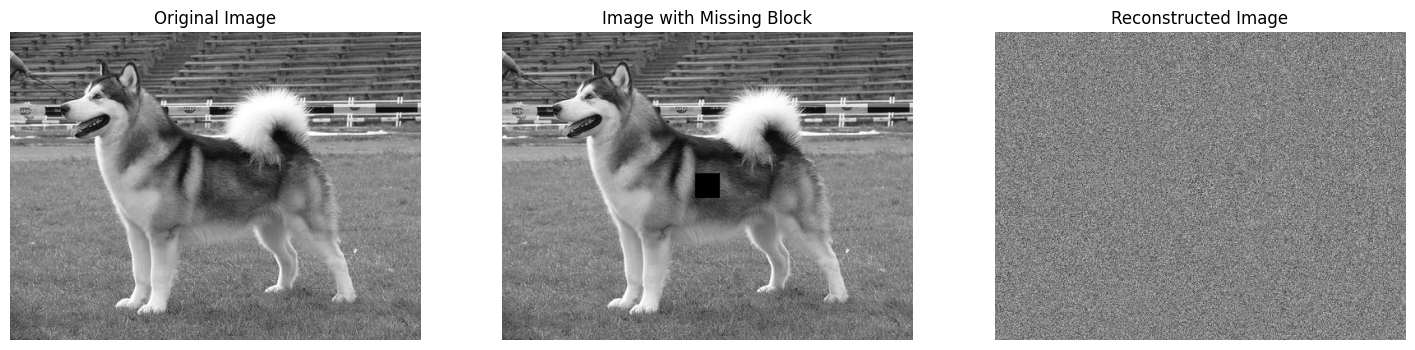

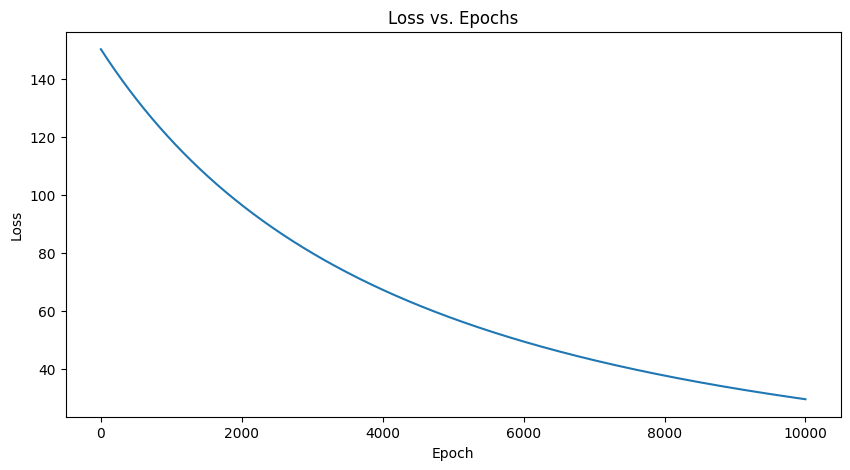

In [14]:
final_reconst_img = U @ V
final_reconst_tensor = final_reconst_img.detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(gray_img_tensor, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(corrupted_img, cmap='gray')
ax[1].set_title("Image with Missing Block")
ax[1].axis('off')

ax[2].imshow(final_reconst_tensor, cmap='gray')
ax[2].set_title("Reconstructed Image")
ax[2].axis('off')

plt.show()

# You can also plot the loss to see if the model trained correctly
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()